# Table of Contents
 <p><div class="lev1"><a href="#Reproduce-Torch-gradient-descent">Reproduce Torch gradient descent</a></div><div class="lev2"><a href="#Convert-MNIST-csv-data-to-numpy">Convert MNIST csv data to numpy</a></div><div class="lev2"><a href="#Reproduce-loss-on-first-example">Reproduce loss on first example</a></div><div class="lev2"><a href="#Reproduce-gradient-on-first-example">Reproduce gradient on first example</a></div><div class="lev3"><a href="#Get-gradients-in-TensorFlow">Get gradients in TensorFlow</a></div><div class="lev2"><a href="#Get-gradients/parameters-from-Lua">Get gradients/parameters from Lua</a></div><div class="lev2"><a href="#Reproduce-MNIST-sgd">Reproduce MNIST sgd</a></div><div class="lev3"><a href="#Feed-lua-params-back-into-TensorFlow">Feed lua params back into TensorFlow</a></div><div class="lev1"><a href="#Reproduce-Torch-l-BFGS">Reproduce Torch l-BFGS</a></div><div class="lev2"><a href="#Load-intermediate-values">Load intermediate values</a></div><div class="lev2"><a href="#Reproduce-two-step-recursion">Reproduce two step recursion</a></div><div class="lev3"><a href="#Step-0">Step 0</a></div><div class="lev3"><a href="#Step-1">Step 1</a></div><div class="lev3"><a href="#Scratch">Scratch</a></div><div class="lev4"><a href="#Tensor-difference-discrepancy">Tensor difference discrepancy</a></div><div class="lev2"><a href="#Reproduce-Torch-l-BFGS-in-Immediate">Reproduce Torch l-BFGS in Immediate</a></div><div class="lev1"><a href="#Scratch">Scratch</a></div><div class="lev2"><a href="#Accessing-elements-question">Accessing elements question</a></div><div class="lev2"><a href="#Derivatives">Derivatives</a></div><div class="lev2"><a href="#Tensor-shape-question">Tensor shape question</a></div>

In [1]:
import os, sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [580]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tensorflow as tf
import numpy as np
from tensorflow.python.client import device_lib
import tensorflow.contrib.immediate as immediate

device_names = [d.name for d in device_lib.list_local_devices()]
print device_names

[u'/cpu:0']


# Reproduce Torch gradient descent

## Convert MNIST csv data to numpy

In [4]:
data = np.loadtxt("mnist.t7/test_32x32.t7.csv.data", dtype=np.uint8).reshape(10000, 32, 32)
np.save("mnist.t7/test_32x32.npy", data)

In [6]:
data = np.loadtxt("mnist.t7/train_32x32.t7.csv.data", dtype=np.uint8).reshape(60000, 32, 32)
np.save("mnist.t7/train_32x32.npy", data)

In [8]:
data = np.loadtxt("mnist.t7/train_32x32.t7.csv.labels", dtype=np.uint8)
np.save("mnist.t7/train_labels.npy", data)

In [9]:
data = np.loadtxt("mnist.t7/test_32x32.t7.csv.labels", dtype=np.uint8)
np.save("mnist.t7/test_labels.npy", data)

## Reproduce loss on first example

In [11]:
train_data = np.load("mnist.t7/train_32x32.npy")

In [47]:
train_labels = np.load("mnist.t7/train_labels.npy")

In [32]:
env = immediate.Env(tf)
tfi = env.tf

In [74]:
i = 0
W = tfi.ones((10, 1024), dtype=tf.float32)
b = tfi.ones((10, 1), dtype=tf.float32)
x = env.numpy_to_itensor(train_data[i], dtype=tf.float32)
x_flat = tfi.reshape(x, (1024, 1))
logits = tfi.matmul(W, x_flat)+b
targets = tfi.one_hot(train_labels[i]-1, 10)  # Lua labels are off-by-one
targets = tfi.reshape(targets, (1, 10))
logits = tfi.reshape(logits, (1, 10))
cross_entropy = tfi.nn.softmax_cross_entropy_with_logits(logits, targets)

In [75]:
cross_entropy

ITensor([ 2.30258512], dtype=float32)

## Reproduce gradient on first example

In [77]:
lua_grad = np.loadtxt("first_grad.csv", dtype=np.float32)

In [125]:
tfi.reduce_sum(lua_grad)

ITensor(0.0186698, dtype=float32)

In [129]:
lua_grad.shape

(10250,)

In [133]:
lua_grad[-10:]

array([ 0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
       -0.89999998,  0.1       ,  0.1       ,  0.1       ,  0.1       ], dtype=float32)

### Get gradients in TensorFlow

In [855]:
dtype = tf.float64
W = tf.Variable(tf.ones_initializer((10, 1024), dtype=dtype))
b = tf.Variable(tf.ones_initializer((10, 1), dtype=dtype))
x = tf.constant(train_data[i], dtype=dtype)
x_flat = tf.reshape(x, (1024, 1))
logits = tf.matmul(W, x_flat)+b
targets = tf.one_hot(train_labels[i]-1, 10, dtype=dtype)  # Lua labels are off-by-one
targets = tf.reshape(targets, (1, 10))
logits = tf.reshape(logits, (1, 10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, targets)
gradients = tf.gradients(cross_entropy, [W, b])

In [157]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [156]:
sess.run(gradients[1])

array([[ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [-0.9],
       [ 0.1],
       [ 0.1]])

In [149]:
sess.run(targets)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

In [150]:
train_labels[0]

6

## Get gradients/parameters from Lua

In [481]:
lua_grads = []
lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(grad_fname) or not os.path.exists(param_fname):
        break
    lua_grads.append(np.loadtxt(grad_fname))
    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))

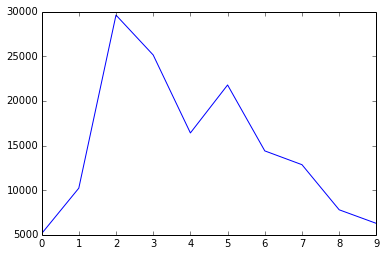

In [483]:
plt.plot(lua_fvals)

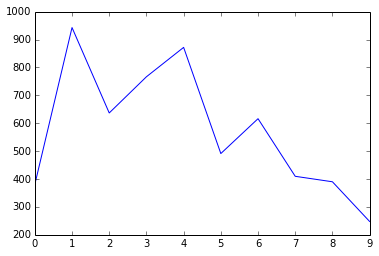

In [484]:
plt.plot([np.linalg.norm(x) for x in lua_grads])

## Reproduce MNIST sgd

In [440]:
train_data = np.load("mnist.t7/train_32x32.npy")
train_data_flat = train_data.reshape((-1, 1024))
train_labels = np.load("mnist.t7/train_labels.npy")
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [459]:
def concat_flatten(tensors):
    """Flattens tensors, concats them"""
    flat_tensors = []
    for tensor in tensors:
        flat_tensors.append(tf.reshape(tensor, [-1]))
    return tf.concat(0, flat_tensors)

In [552]:
dtype = tf.float64
batchSize = 100
learningRate = 0.1

tf.reset_default_graph()

W = tf.Variable(tf.ones_initializer((1024, 10), dtype=dtype))
b = tf.Variable(tf.ones_initializer((1, 10), dtype=dtype))
x = tf.Variable(tf.zeros_initializer((batchSize, 1024), dtype=dtype))
targets = tf.Variable(tf.zeros_initializer((batchSize, 10), dtype=dtype))
logits = tf.matmul(x, W) + b

# cross entropy expects batch dimension to be first, transpose inputs
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, targets)
cross_entropy_loss = tf.reduce_mean(cross_entropy)
Wnorm = tf.reduce_sum(tf.square(W))
bnorm = tf.reduce_sum(tf.square(b))
loss = cross_entropy_loss + (bnorm + Wnorm)/2

# grads = tf.gradients(loss, [W, b])
opt = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
grads_and_vars = opt.compute_gradients(loss, [W, b])
train_step = opt.apply_gradients(grads_and_vars)

W_grad = grads_and_vars[0][0]
b_grad = grads_and_vars[1][0]
flat_grad = concat_flatten([tf.transpose(W_grad), b_grad])
# flat_grad = concat_flatten([grad_and_var[0] for grad_and_var in grads_and_vars])
flat_params = concat_flatten([W, b])

# initialize x and targets
x_placeholder = tf.placeholder(dtype=dtype)
x_init = x.assign(x_placeholder)

# initialize labels
labels_placeholder = tf.placeholder(shape=(batchSize), dtype=tf.int32)
labels_onehot = tf.one_hot(labels_placeholder - 1, 10, dtype=dtype)  # Lua labels are off-by-one
targets_init = targets.assign(labels_onehot)

sess = tf.InteractiveSession()
sess.run(x_init, feed_dict={x_placeholder:train_data_flat[:batchSize]})
sess.run(targets_init, feed_dict={labels_placeholder: train_labels[:batchSize]})
sess.run([W.initializer, b.initializer])
print(sess.run(loss))

5127.30258509


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x12e7d31d0>> ignored


In [553]:
tf_grads = []
tf_params = []
tf_fvals = []
for i in range(10):
    tf_grads.append(sess.run(flat_grad))
    tf_params.append(sess.run(flat_params))
    tf_fvals.append(sess.run(loss))
    print(tf_fvals[-1])
    sess.run(train_step)

5127.30258509
10222.2878245
29610.151198
25141.4119371
16409.1374003
21781.9665362
14398.5814516
12851.5786807
7800.24671143
6276.07440723


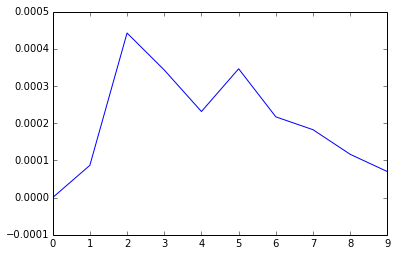

In [543]:
tf_fvals_np = np.array(tf_fvals)
lua_fvals_np = np.array(lua_fvals)
plt.plot(tf_fvals_np - lua_fvals_np)

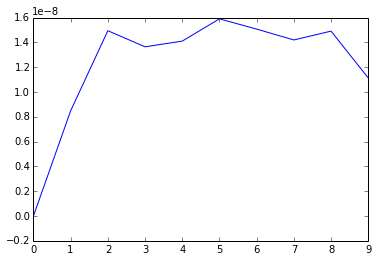

In [544]:
plt.plot((tf_fvals_np - lua_fvals_np)/lua_fvals_np)

### Feed lua params back into TensorFlow

Get the values from Lua, feed them into TensorFlow to get updated grad value

In [577]:
iternum = 1
# convert lua_W from column major to row major
lua_W_flat = lua_params[iternum][:-10]
lua_W = lua_W_flat.reshape((10, 1024))
tf_W = lua_W.T
lua_b = lua_params[iternum][-10:]
tf_b = lua_b.reshape((1, -1))

In [578]:
sess.run(loss, feed_dict={W: tf_W, b: tf_b})

10222.287737750139

In [579]:
lua_fvals[1]

array(10222.28773775)

# Reproduce Torch l-BFGS

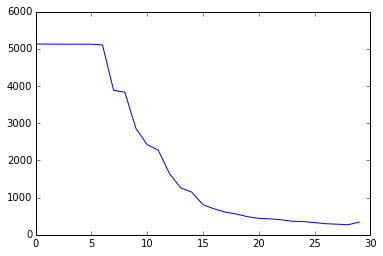

In [582]:
lua_grads = []
lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(grad_fname) or not os.path.exists(param_fname):
        break
    lua_grads.append(np.loadtxt(grad_fname))
    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

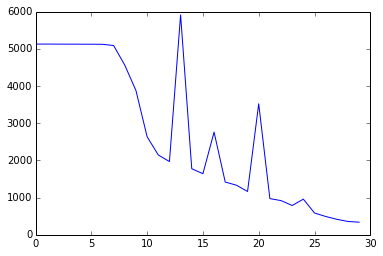

In [583]:
lua_grads = []
lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(grad_fname) or not os.path.exists(param_fname):
        break
    lua_grads.append(np.loadtxt(grad_fname))
    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

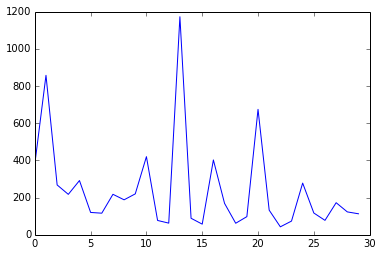

In [585]:
plt.plot([np.linalg.norm(g) for g in lua_grads])

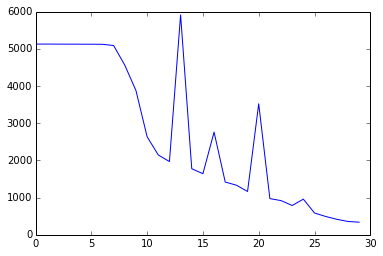

In [590]:
#lua_grads = []
#lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
#    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(fval_fname):
        break
#    lua_grads.append(np.loadtxt(grad_fname))
#    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

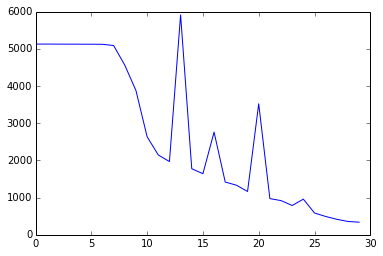

In [591]:
#lua_grads = []
#lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
#    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(fval_fname):
        break
#    lua_grads.append(np.loadtxt(grad_fname))
#    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

## Load intermediate values

In [657]:
class Step(object):
    pass

In [1011]:
def tryload(fname):
    if os.path.exists(fname):
        return np.loadtxt(fname, dtype=np.float64)
    else:
        return None
    
def loadStep(i):
    step = Step()
    step.al = tryload("stepdata/al-"+str(i))
    step.q = tryload("stepdata/q-"+str(i))
    step.ro = tryload("stepdata/ro-"+str(i))
    step.g = tryload("stepdata/g-"+str(i))
    step.x = tryload("stepdata/x-"+str(i))
    step.f = tryload("stepdata/f-"+str(i))
    step.Hdiag = tryload("stepdata/Hdiag-"+str(i))
    step.d = tryload("stepdata/d-"+str(i))
    step.be_i = tryload("stepdata/be_i-"+str(i))
    step.r = tryload("stepdata/r-"+str(i))
    step.y = tryload("stepdata/y-"+str(i))
    step.s = tryload("stepdata/s-"+str(i))
    step.tmp1 = tryload("stepdata/tmp1-"+str(i))
    step.tmp11 = tryload("stepdata/tmp11-"+str(i))
    step.ys = tryload("stepdata/ys-"+str(i))
    step.gtd = tryload("stepdata/gtd-"+str(i))
    step.t = tryload("stepdata/t-"+str(i))
    step.fdiff = tryload("stepdata/fdiff-"+str(i))
    return step

In [1014]:
steps = [loadStep(i) for i in range(0, 30)]

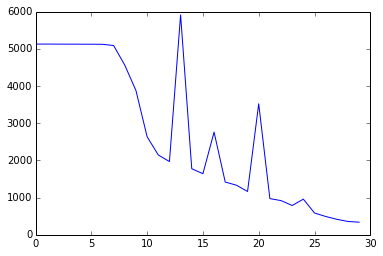

In [1015]:
plt.plot([step.f for step in steps])

In [1139]:
np.testing.

NameError: name 'numpy' is not defined

In [1138]:
steps[0].f

array(5127.302585093)

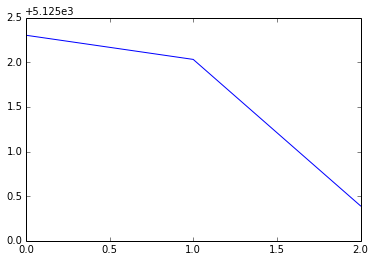

In [991]:
plt.plot([step.f for step in steps])

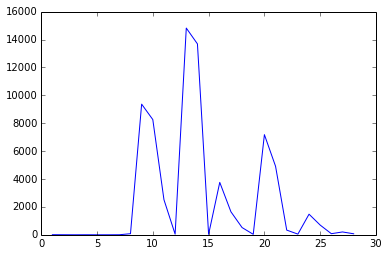

In [895]:
plt.plot([step.ys for step in steps])

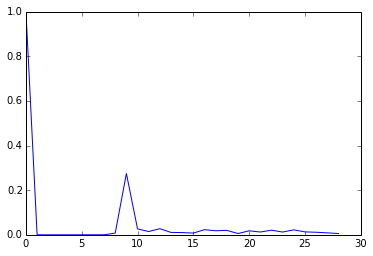

In [861]:
plt.plot([step.Hdiag for step in steps])

In [689]:
def maxdiff(a, b):
    return np.max((a-b)/b)

In [691]:
def RelativeError(new_val, reference_val, atol = 2.**-53):
  return np.max(np.abs(new_val - reference_val) / (atol + np.abs(reference_val)))

In [949]:
from numpy.testing.utils import nulp_diff
def ulp_diff(a, b):
    try:
        return max(nulp_diff(a.astype(np.float32), b.astype(np.float32)))
    except:
        return nulp_diff(a.astype(np.float32), b.astype(np.float32))
    
def check(a, b, msg):
    diff = ulp_diff(np.asarray(a), np.asarray(b))
    if diff>0:
        print("%s %f"%(msg, diff))
    else:
        print("%s OK"%(msg))

## Reproduce two step recursion

### Step 0

In [1140]:
old_dirs = []
old_stps = []
nCorrection = 100
ro = np.zeros((nCorrection,), dtype=np.float64)
al = np.zeros((nCorrection,), dtype=np.float64)

# step 0
learningRate = 1.
x = steps[0].x
g = steps[0].g
f = steps[0].f

# step 1
ii=1
d = -g
check(steps[ii].d, d, "d")

f_old = f
g_old = g

gtd = np.dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

tmp1 = np.abs(np.array(g))
t = min(1, 1/tmp1.sum())
check(steps[ii].t, t, "t")

f = steps[ii].f
x = x + t*d
check(steps[ii].x, x, "x")
g = steps[ii].g

tmp1 = np.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

tmp11 = np.abs(d*t)
check(steps[ii].tmp11, tmp11, "tmp11")

check(steps[ii].fdiff, f-f_old, "fdiff")

# step 2
ii = 2
y = g - g_old
check(steps[ii].y, y, "y")
s = d*t
check(steps[ii].s, s, "s")

old_dirs.append(s)
old_stps.append(y)

ys = np.dot(y, s)
check(steps[ii].ys, ys, "ys")

Hdiag = ys/np.dot(y, y)
check(steps[ii].Hdiag, Hdiag, "Hdiag")


k = len(old_dirs)
for i in range(k):
    ro[i] = 1/old_stps[i].dot(old_dirs[i])
check(steps[ii].ro, ro, "ro")

q = -g
for i in range(k-1, -1, -1):
    al[i] = old_dirs[i].dot(q) * ro[i]
    q = q - al[i]*old_stps[i]
    
check(steps[ii].q, q, "q")
check(steps[ii].al, al, "al")

r = q*Hdiag
for i in range(k):
    be_i = old_stps[i].dot(r) * ro[i]
    r += (al[i]-be_i)*old_dirs[i]
d = r
    
check(steps[ii].d, d, "d")
check(steps[ii].r, r, "r")

g_old = g
f_old = f

gtd = np.dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

t = learningRate
check(steps[ii].t, t, "t")

x = x + t*d
check(steps[ii].x, x, "x")
f = steps[ii].f
g = steps[ii].g

tmp1 = np.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

check(steps[ii].fdiff, f - f_old, "fdiff")
#fdiff = steps[ii].f - steps[0].f
#check(steps[ii].fdiff, fdiff, "fdiff")


#gtd = g.dot(d)
#check(step)

AttributeError: 'numpy.ndarray' object has no attribute 'as_numpy'

In [1019]:
check(steps[ii].d, steps[ii].r, "hi")

hi OK


In [1009]:
max(steps[2].ro[1:])

1.0

In [1010]:
np.argmax(steps[2].ro[1:])

88

In [1002]:
np.loadtxt('stepdata/ro-2')

array([  1.36814084e-001,   1.72723371e-077,   1.72723371e-077,
         9.73469813e-309,   4.94065646e-324,   1.11253693e-308,
         4.94065646e-324,   1.25160405e-308,   6.93486243e-310,
         4.94065646e-324,   1.48539705e-313,   8.24599674e-316,
         0.00000000e+000,   0.00000000e+000,   1.72723371e-077,
         1.72723371e-077,   1.72723371e-077,   1.72723371e-077,
         1.13289253e-320,   2.78134232e-309,   6.93486243e-310,
         4.94065646e-324,   1.48539705e-313,   8.24599674e-316,
         0.00000000e+000,   0.00000000e+000,   1.72723371e-077,
         1.72723371e-077,   1.72723371e-077,   1.72723371e-077,
         1.72723371e-077,   1.72723371e-077,   1.12943407e-320,
         6.93486233e-310,   2.88376236e-319,   2.12199579e-314,
         1.72723371e-077,   1.72723371e-077,   1.12795187e-320,
         2.78134232e-309,   5.05923221e-321,   1.58101007e-322,
         4.94065646e-324,   4.94065646e-324,   1.72723371e-077,
         1.72723371e-077,   1.12597561e-

In [971]:
steps[1].gtd

array(-144861.74155)

### Step 1 

In [799]:
steps[1].d2

array([-1.  , -1.  , -1.  , ..., -1.  , -1.02, -0.99])

In [785]:
steps[1].s

array([ -4.03784364e-05,  -4.03784364e-05,  -4.03784364e-05, ...,
        -8.78469978e-02,  -8.88552829e-02,  -5.76157692e-02])

### Scratch

#### Tensor difference discrepancy

In [733]:
val1 = np.loadtxt("stepdata/temp0")
val2 = np.loadtxt("stepdata/temp1")
val3 = np.loadtxt("stepdata/temp2")

In [736]:
nulp_diff(val1-val2, val3)

180154.0

In [747]:
nulp_diff((val1-val2).astype(np.float32), val3.astype(np.float32))

0.0

In [740]:
nulp_diff(env.tf.sub(val1, val2).as_numpy(), val3)

2335133695930.0

In [745]:
env.tf.sub(val1, val2).as_numpy()

-0.27099609

In [746]:
val1-val2

-0.27086646780026058

## Reproduce Torch l-BFGS in Immediate

In [1078]:
type(np.zeros(3)).__name__

'ndarray'

In [1108]:
from numpy.testing.utils import nulp_diff
def ulp_diff(a, b):
    try:
        return max(nulp_diff(a.astype(np.float32), b.astype(np.float32)))
    except:
        return nulp_diff(a.astype(np.float32), b.astype(np.float32))
    
def check(a, b, msg):
    b = b.as_numpy()
    diff = ulp_diff(np.asarray(a), np.asarray(b))
    if diff>10:
        print("%s %f"%(msg, diff))
    else:
        print("%s OK"%(msg))

In [1085]:
import tensorflow as tf
env = immediate.Env(tf)
im = env.tf

In [1086]:
def dot(a, b):
    return im.reduce_sum(a*b)

In [1134]:
old_dirs = []
old_stps = []
nCorrection = 100
#ro = im.zeros((nCorrection,), dtype=im.float64)
ro = [0]*nCorrection
al = [0]*nCorrection
#al = im.zeros((nCorrection,), dtype=im.float64)


# step 0
learningRate = env.numpy_to_itensor(1., dtype=im.float64)
x = env.numpy_to_itensor(steps[0].x, dtype=im.float64)
g = env.numpy_to_itensor(steps[0].g, dtype=im.float64)
f = env.numpy_to_itensor(steps[0].f, dtype=im.float64)

# step 1
ii=1
d = -g
check(steps[ii].d, d, "d")

f_old = f
g_old = g

gtd = dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

tmp1 = im.abs(g)
t = min(1, im.div(1, im.reduce_sum(tmp1)))
check(steps[ii].t, t, "t")

f = env.numpy_to_itensor(steps[ii].f, dtype=im.float64)
x = x + t*d
check(steps[ii].x, x, "x")
g = env.numpy_to_itensor(steps[ii].g, dtype=im.float64)

tmp1 = im.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

tmp11 = im.abs(d*t)
check(steps[ii].tmp11, tmp11, "tmp11")
check(steps[ii].fdiff, f-f_old, "fdiff")

# step 2
ii = 2
y = g - g_old
check(steps[ii].y, y, "y")
s = d*t
check(steps[ii].s, s, "s")

old_dirs.append(s)
old_stps.append(y)
Hdiag = im.div(ys, dot(y, y))
check(steps[ii].Hdiag, Hdiag, "Hdiag")

ys = dot(y, s)
check(steps[ii].ys, ys, "ys")

k = len(old_dirs)
for i in range(k):
    ro[i] = im.div(1, dot(old_stps[i], old_dirs[i]))
    
check(steps[ii].ro, im.pack(ro), "ro")

q = -g
for i in range(k-1, -1, -1):
    al[i] = dot(old_dirs[i], q) * ro[i]
    q = q - al[i]*old_stps[i]

check(steps[ii].q, q, "q")
check(steps[ii].al, im.pack(al), "al")

r = q*Hdiag
for i in range(k):
    be_i = dot(old_stps[i], r) * ro[i]
    r += (al[i]-be_i)*old_dirs[i]
d = r

check(steps[ii].d, d, "d")
check(steps[ii].r, r, "r")

g_old = g
f_old = f

gtd = dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

t = learningRate
check(steps[ii].t, t, "t")

x = x + t*d
check(steps[ii].x, x, "x")

f = env.numpy_to_itensor(steps[ii].f, dtype=im.float64)
g = env.numpy_to_itensor(steps[ii].g, dtype=im.float64)

tmp1 = im.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

check(steps[ii].fdiff, f - f_old, "fdiff")


d OK
gtd OK
t OK
x OK
tmp1 OK
tmp11 OK
fdiff OK
y OK
s OK
Hdiag OK
ys OK
ro OK
q OK
al OK
d OK
r OK
gtd OK
t OK
x OK
tmp1 OK
fdiff OK


In [1129]:
t

1.0

In [ ]:
#fdiff = steps[ii].f - steps[0].f
#check(steps[ii].fdiff, fdiff, "fdiff")


#gtd = g.dot(d)
#check(step)

In [1048]:
from numpy.testing.utils import nulp_diff
a = np.loadtxt("stepdata/temp")
temp = np.loadtxt("stepdata/temp")
lua_result = np.loadtxt("stepdata/tempsum")
np_result = a.sum()

In [1049]:
nulp_diff(lua_result, np_result)

414.0

In [1054]:
temp.dtype

dtype('float64')

In [1061]:
tf_result = im.reduce_sum(env.numpy_to_itensor(temp, dtype=im.float64)).as_numpy()

In [1063]:
nulp_diff(tf_result, lua_result)

156.0

# Scratch

In [816]:
a = env.numpy_to_itensor([[1,1],[1,1]], dtype=tf.float64)
b = env.numpy_to_itensor([[1,1],[1,1]], dtype=tf.float64)
env.tf.abs(a)

ITensor([[ 1.  1.]
 [ 1.  1.]], dtype=float64)

In [818]:
env.tf.matmul(a, b)

ITensor([[ 2.  2.]
 [ 2.  2.]], dtype=float64)

In [821]:
env.tf.div(a, b)

ITensor([[ 1.  1.]
 [ 1.  1.]], dtype=float64)

In [823]:
env.tf.nn.softmax_cross_entropy_with_logits(a, b)

ITensor([ 1.38629436  1.38629436], dtype=float64)

In [827]:
tf.one_hot??

## Accessing elements question

In [ ]:
import tensorflow as tf
import numpy as np

def assignC():
    C_copy = np.zeros((2,2))
    C = tf.matmul(tf.transpose(x), x)
    C_copy[0,0] = C[0,0]
    #C_copy[0,0] = C[0,0].eval() # error saying "You must feed a value for  placeholder tensor 'Placeholder' with dtype float" at line 17
    print(C_copy[0,0])
    return C_copy

sess = tf.InteractiveSession()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

x = tf.placeholder(tf.float32, [None, 1024])

sess.run(tf.initialize_all_variables())
for i in range(1):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    print(sess.run(tf.identity(assignC()), feed_dict={x: batch_xs}))


In [850]:
tf.reset_default_graph()
C = tf.ones((3,3))

In [854]:
C[0,0]

<tf.Tensor 'Squeeze_2:0' shape=() dtype=float32>

In [852]:
tf.get_default_graph().as_graph_def()

node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 3
          }
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Slice/begin"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\000\000\000\000\000\000"
      }
    }
  }
}
node {
  name: "Slice/size"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\00

## Derivatives

In [814]:
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32)
a = x*x
E = 2*a
(dEda, dEdx) = tf.gradients(E, xs=[a, x])
sess = tf.Session()
sess.run([dEda, dEdx], feed_dict={x: 1})

[2.0, 4.0]

In [810]:
grads

[<tf.Tensor 'gradients/mul_1_grad/Reshape_1:0' shape=() dtype=float32>,
 <tf.Tensor 'gradients/AddN:0' shape=() dtype=float32>]

In [813]:
tf.gradients??

## Tensor shape question

In [449]:
batch_size = tf.shape(tf.ones((10,10)))
print(tf.zeros((batch_size, 128)).get_shape())

ValueError: Shapes (2,) and () are not compatible

In [452]:
batch_size=tf.shape(tf.ones((10,10)))[0]

In [454]:
batch_size

<tf.Tensor 'Squeeze_1:0' shape=() dtype=int32>

In [443]:
print(tf.zeros((batch_size, 128)).get_shape())

(100, 128)


In [457]:
asdf=tf.Variable??

In [ ]:
asdf=tf.Variable

In [453]:
print(tf.zeros((batch_size, 128)).get_shape())

(?, ?)


In [27]:
import tensorflow as tf
nInputs = 6
nUnitsLayer1 = 3
weights = tf.Variable(tf.truncated_normal([nInputs, nUnitsLayer1]))
biases= tf.Variable(tf.zeros(nUnitsLayer1))

print 'nInputs', nInputs
print 'nUnitsLayer1', nUnitsLayer1
print 'weights shape', tf.shape(weights)
print 'biases shape', tf.shape(biases)

init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    print 'weights'
    print (weights.eval())
    print 'biases'
    print (biases.eval())


nInputs 6
nUnitsLayer1 3
weights shape Tensor("Shape:0", shape=(2,), dtype=int32)
biases shape Tensor("Shape_1:0", shape=(1,), dtype=int32)
weights
[[-0.42564794  1.32690036 -0.57812071]
 [ 1.3026278  -1.29796839 -1.02938724]
 [ 0.19238499  1.10781586 -0.24808854]
 [-0.60994369 -0.30048054  0.5742262 ]
 [ 0.13138418 -0.60150367  0.44378978]
 [ 0.42674765 -0.44903693  0.32681581]]
biases
[ 0.  0.  0.]


In [28]:
weights.get_shape()

TensorShape([Dimension(6), Dimension(3)])

In [29]:
weights

In [31]:
tf.shape(weights).get_shape

TensorShape([Dimension(2)])

In [163]:
tf.group(tf.constant(1))

In [164]:
stf.nn.top_k([1,2,3])

TopKV2(values=<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>, indices=<tf.Tensor 'TopKV2:1' shape=(1,) dtype=int32>)

In [166]:
tf.split(0, 2, [1,2])

[<tf.Tensor 'split:0' shape=(1,) dtype=int32>,
 <tf.Tensor 'split:1' shape=(1,) dtype=int32>]

In [168]:
tf.reset_default_graph()
sess.run(tf.nn.top_k([1,2,3]))

ValueError: Fetch argument <tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32> of <tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32> cannot be interpreted as a Tensor. (Tensor Tensor("TopKV2:0", shape=(1,), dtype=int32) is not an element of this graph.)

In [176]:
tf.reset_default_graph()
op = tf.nn.top_k([1,2,3])
sess = tf.Session()

In [177]:
tf.get_default_graph().as_graph_def()

node {
  name: "TopKV2/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 3
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000\003\000\000\000"
      }
    }
  }
}
node {
  name: "TopKV2/k"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
node {
  name: "TopKV2"
  op: "TopKV2"
  input: "TopKV2/input"
  input: "TopKV2/k"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "sorted"
    value {
      b: true
    }
  }
}
versions {
  producer: 10
}

In [179]:
sess.run(["TopKV2:0"])

[array([3], dtype=int32)]

In [181]:
tf.reset_default_graph()
op = tf.split(0, 2, [1,2])
sess = tf.Session()

In [182]:
tf.get_default_graph().as_graph_def()

node {
  name: "split/split_dim"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 0
      }
    }
  }
}
node {
  name: "split/value"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000"
      }
    }
  }
}
node {
  name: "split"
  op: "Split"
  input: "split/split_dim"
  input: "split/value"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "num_split"
    value {
      i: 2
    }
  }
}
versions {
  producer: 10
}

In [184]:
sess.run("split:1")

array([2], dtype=int32)

In [185]:
op

[<tf.Tensor 'split:0' shape=(1,) dtype=int32>,
 <tf.Tensor 'split:1' shape=(1,) dtype=int32>]

In [193]:
tf.reset_default_graph()
op = tf.nn.top_k([1,2,3])
sess = tf.InteractiveSession()
sess.run(tf.nn.top_k([1,2,3]))

[array([3], dtype=int32), array([2], dtype=int32)]

In [197]:
op[0]

<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>

In [205]:
op.values

<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>

In [206]:
op = tf.split(0,3, [1,2,3])

In [208]:
tf.get_default_graph().as_graph_def()

node {
  name: "TopKV2/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 3
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000\003\000\000\000"
      }
    }
  }
}
node {
  name: "TopKV2/k"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
node {
  name: "TopKV2"
  op: "TopKV2"
  input: "TopKV2/input"
  input: "TopKV2/k"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "sorted"
    value {
      b: true
    }
  }
}
node {
  name: "TopKV2_1/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tens

In [213]:
tf.reset_default_graph()
a = tf.Variable(tf.ones_initializer((3,3)))
init_op = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init_op)
print(tf.get_default_graph().as_graph_def())
print sess.run(["Variable:0"])

node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 3
          }
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Variable"
  op: "Variable"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 3
        }
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "Variable/Assign"
  op: "Assign"
  input: "Variable"
  input: "ones"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@Variable"
      }
    }
  }
  

In [215]:
print sess.run(["Variable:0"])

[array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)]


In [216]:
tf.reset_default_graph()
tf.constant(1)
print(tf.get_default_graph().as_graph_def())


node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
versions {
  producer: 10
}



In [219]:
    tf.reset_default_graph()
    value = tf.constant(1)
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()


node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
versions {
  producer: 10
}



In [222]:
sess.run("Const:0")

1

In [232]:
    tf.reset_default_graph()
    value = tf.Variable(tf.ones_initializer(()))
    value2 = value+3
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()
    sess.run(tf.initialize_all_variables())


node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Variable"
  op: "Variable"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "Variable/Assign"
  op: "Assign"
  input: "Variable"
  input: "ones"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@Variable"
      }
    }
  }
  attr {
    key: "use_locking"
    value {
      b: true
    }
  }
  attr {
    key: "validate_shape"
    value {
      b: true
    }
  }
}
node {
  name: "Variable/read"
  op: "Ide

In [227]:
type(value)

tensorflow.python.ops.variables.Variable

In [228]:
value.name

u'Variable:0'

In [233]:
sess.run("Variable:0")

1.0

In [236]:
    tf.reset_default_graph()
    value = tf.placeholder(tf.uint8)
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()
    sess.run(tf.identity(value), feed_dict={"Placeholder:0":2})


node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_UINT8
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
versions {
  producer: 10
}



Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x12aadfb90>> ignored


2

In [235]:
value

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=uint8>

In [593]:
tf.FIFOQueue(1000, )

In [596]:
tf.train.Saver??

In [595]:
a.save??

In [607]:
tf.reset_default_graph()
a = tf.ones((3,3))
b = tf.ones((3,3))
a.__add__(b)

<tf.Tensor 'add:0' shape=(3, 3) dtype=float32>

In [609]:
method=a.__add__

In [610]:
method??

In [604]:
a+b

<tf.Tensor 'add_7:0' shape=(3, 3) dtype=float32>

In [606]:
a.__add__??

In [611]:
dir(a)

['OVERLOADABLE_OPERATORS',
 '__abs__',
 '__add__',
 '__and__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__invert__',
 '__iter__',
 '__le__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',
 '_as_node_def_input',
 '_consumers',
 '_dtype',
 '_op',
 '_override_operator',
 '_shape',
 '_shape_as_list',
 '_value_index',
 'consumers',
 'device',
 'dtype',
 'eval',
 'get_shape',
 'graph',
 'name',
 'op',
 'set_sh

In [612]:
a.OVERLOADABLE_OPERATORS

{'__abs__',
 '__add__',
 '__and__',
 '__div__',
 '__floordiv__',
 '__ge__',
 '__getitem__',
 '__gt__',
 '__invert__',
 '__le__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__neg__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__sub__',
 '__truediv__',
 '__xor__'}

In [615]:
func_mod = tf.Tensor.__mod__

In [617]:
func_mod??

In [619]:
tf.reset_default_graph()
dtype = tf.int32
a = tf.placeholder(dtype)
b = tf.placeholder(dtype)
c = a+b

In [620]:
c

<tf.Tensor 'add:0' shape=<unknown> dtype=int32>

In [643]:
tf.reset_default_graph()
dtype = tf.int32
a = tf.placeholder(dtype)
b = tf.placeholder(dtype)
c = tf.add(a, b)

In [644]:
tf.get_default_graph().as_graph_def()

node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "Placeholder_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "Add"
  op: "Add"
  input: "Placeholder"
  input: "Placeholder_1"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
versions {
  producer: 10
}

In [624]:
import inspect

In [625]:
inspect.getsource(a.__add__)

'def to_bfloat16(x, name="ToBFloat16"):\n  """Casts a tensor to type `bfloat16`.\n\n  Args:\n    x: A `Tensor` or `SparseTensor`.\n    name: A name for the operation (optional).\n\n  Returns:\n    A `Tensor` or `SparseTensor` with same shape as `x` with type `bfloat16`.\n\n  Raises:\n    TypeError: If `x` cannot be cast to the `bfloat16`.\n  """\n  return cast(x, dtypes.bfloat16, name=name)\n'

In [626]:
inspect.getfile(a.__add__)

'/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/python/ops/math_ops.py'

In [627]:
type(a.__add__)

instancemethod

In [629]:
type(tf.Tensor.__add__)

instancemethod

In [630]:
inspect.getsource(tf.Tensor.__add__)

'def to_bfloat16(x, name="ToBFloat16"):\n  """Casts a tensor to type `bfloat16`.\n\n  Args:\n    x: A `Tensor` or `SparseTensor`.\n    name: A name for the operation (optional).\n\n  Returns:\n    A `Tensor` or `SparseTensor` with same shape as `x` with type `bfloat16`.\n\n  Raises:\n    TypeError: If `x` cannot be cast to the `bfloat16`.\n  """\n  return cast(x, dtypes.bfloat16, name=name)\n'

In [631]:
stuff = tf.Tensor.__add__

In [633]:
stuff.im_func.func_closure

(<cell at 0x125687868: function object at 0x1254f7d70>,
 <cell at 0x1256878a0: str object at 0x10c0ac0a8>)

In [637]:
real_function = tf.Tensor.__add__.im_func.func_closure[0].cell_contents

In [654]:
tf.add.__module__ + "." + tf.add.__name__

'tensorflow.python.ops.gen_math_ops.add'

In [642]:
tf.add

<function tensorflow.python.ops.gen_math_ops.add>

In [655]:
tf.Tensor.OVERLOADABLE_OPERATORS

{'__abs__',
 '__add__',
 '__and__',
 '__div__',
 '__floordiv__',
 '__ge__',
 '__getitem__',
 '__gt__',
 '__invert__',
 '__le__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__neg__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__sub__',
 '__truediv__',
 '__xor__'}

In [1050]:
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 bus_adjacency: BUS_ANY
 incarnation: 12496753478763930059]

In [664]:
input_tensor = tf.placeholder(tf.float32, [None, 32])
batch_size = tf.shape(input_tensor)[0]

res = tf.zeros((5, 128))
print res.get_shape()  # prints (?, ?) WHEREAS one could expect (?, 128)

res.set_shape([None, 128])
print res.get_shape()  # prints (?, 128)

(5, 128)
(5, 128)


In [845]:
tf.add.__globals__["_op_def_lib"]._ops["Add"].op_def

name: "Add"
input_arg {
  name: "x"
  type_attr: "T"
}
input_arg {
  name: "y"
  type_attr: "T"
}
output_arg {
  name: "z"
  type_attr: "T"
}
attr {
  name: "T"
  type: "type"
  allowed_values {
    list {
      type: DT_HALF
      type: DT_FLOAT
      type: DT_DOUBLE
      type: DT_UINT8
      type: DT_INT8
      type: DT_INT16
      type: DT_INT32
      type: DT_INT64
      type: DT_COMPLEX64
      type: DT_COMPLEX128
      type: DT_STRING
    }
  }
}

In [846]:
tf.add??